In [93]:
import pandas as pd

file_name = "votes.csv"
data = pd.read_csv(file_name)


# Global summary

In [94]:
print(data.describe())

       Whats is your age?  demographic_time  contiguous_box_plots_time  \
count            6.000000         14.000000                  14.000000   
mean            21.500000      10171.714286                3678.214286   
std              0.547723      14145.786975                5806.360533   
min             21.000000        922.000000                 986.000000   
25%             21.000000       1810.500000                1234.500000   
50%             21.500000       3313.500000                1544.000000   
75%             22.000000      12354.250000                1974.000000   
max             22.000000      50724.000000               21007.000000   

       contiguous_md_plots_time  contiguous_violin_plots_time  \
count                 14.000000                     14.000000   
mean                 965.000000                    805.000000   
std                  388.711877                    337.443101   
min                  320.000000                    239.000000   
25%     

## Numerical summary

In [95]:
# keep only numerical columns
numerical_data = data.select_dtypes(include=['number'])
numerical_data.describe()

,Whats is your age?,demographic_time,contiguous_box_plots_time,contiguous_md_plots_time,contiguous_violin_plots_time,contiguous_bean_plots_time,ridgeline_plots_time,contiguous_d_heatmap_plot_time,continuous_colormap_plus_time,overlapping_box_plots_time,...,arc_diagram_plus_vs_overlapping_box_plots_time,arc_diagram_plus_vs_overlapping_md_plots,arc_diagram_plus_vs_overlapping_md_plots_time,arc_diagram_plus_vs_overlapping_violin_plots,arc_diagram_plus_vs_overlapping_violin_plots_time,arc_diagram_plus_vs_overlapping_bean_plots,arc_diagram_plus_vs_overlapping_bean_plots_time,arc_diagram_plus_vs_radial_edge_bundling,arc_diagram_plus_vs_radial_edge_bundling_time,Unnamed: 347
count,6.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,21.500000,10171.714286,3678.214286,965.000000,805.000000,522.071429,1057.285714,727.142857,827.142857,1099.714286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.547723,14145.786975,5806.360533,388.711877,337.443101,186.727883,259.928815,284.852150,456.798366,1063.747760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,21.000000,922.000000,986.000000,320.000000,239.000000,176.000000,778.000000,191.000000,248.000000,445.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,21.000000,1810.500000,1234.500000,784.000000,516.500000,411.000000,844.250000,670.000000,503.500000,582.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,21.500000,3313.500000,1544.000000,905.500000,889.500000,452.000000,977.500000,729.000000,689.000000,690.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,22.000000,12354.250000,1974.000000,1070.000000,1134.500000,629.500000,1208.000000,823.750000,1064.500000,822.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,22.000000,50724.000000,21007.000000,1905.000000,1210.000000,865.000000,1698.000000,1297.000000,1834.000000,4054.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:

columns_names = list(data.columns)
columns_names_vs = list(filter(lambda e : e.__contains__("_vs_") and not e.__contains__("time"), columns_names))
#print(columns_names_vs)

solutions_names = list(set([e.split("_vs_")[0] for e in columns_names_vs] + [e.split("_vs_")[1] for e in columns_names_vs]))
solutions_names.sort()
#print(solutions_names)

vote_data = data[columns_names_vs]
# count the number of each value for each column
count = vote_data.apply(pd.value_counts)

count = count.fillna(0)
#print(count)
#shape of the count
#print(count.shape)

dist_matrix = pd.DataFrame(index=solutions_names, columns=solutions_names)
dist_matrix = dist_matrix.fillna(0)

#print(dist_matrix)

for duel in count.columns:
    #print(duel)
    for index, value in count[duel].iteritems():
        if value == 0:
            continue
        #print(index, value)
        sol1, sol2 = duel.split("_vs_")
        if index == sol1:
            dist_matrix.loc[sol1, sol2] += 1
        elif index == sol2:
            dist_matrix.loc[sol2, sol1] += 1
        else:   # Equal
            dist_matrix.loc[sol1, sol2] += 1
            dist_matrix.loc[sol2, sol1] += 1

print(dist_matrix)
            


                           arc_diagram_plus  contiguous_bean_plots  \
arc_diagram_plus                          0                      0   
contiguous_bean_plots                     0                      0   
contiguous_box_plots                      0                      2   
contiguous_d_heatmap_plot                 0                      1   
contiguous_md_plots                       2                      1   
contiguous_violin_plots                   0                      2   
continuous_colormap_plus                  1                      0   
overlapping_bean_plots                    0                      2   
overlapping_box_plots                     0                      2   
overlapping_md_plots                      1                      0   
overlapping_violin_plots                  1                      1   
radial_edge_bundling                      0                      2   
ridgeline_plots                           0                      1   

                   

C:\Users\tmani\AppData\Local\Temp\ipykernel_2124\2104677215.py:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in count[duel].iteritems():


In [97]:
dist_matrix

,arc_diagram_plus,contiguous_bean_plots,contiguous_box_plots,contiguous_d_heatmap_plot,contiguous_md_plots,contiguous_violin_plots,continuous_colormap_plus,overlapping_bean_plots,overlapping_box_plots,overlapping_md_plots,overlapping_violin_plots,radial_edge_bundling,ridgeline_plots
arc_diagram_plus,0,0,1,1,2,0,1,1,1,1,1,1,1
contiguous_bean_plots,0,0,1,2,0,1,0,1,1,0,0,2,0
contiguous_box_plots,0,2,0,1,2,0,1,0,1,0,1,0,1
contiguous_d_heatmap_plot,0,1,1,0,0,0,0,1,0,1,1,1,0
contiguous_md_plots,2,1,1,0,0,1,0,2,0,1,0,1,1
contiguous_violin_plots,0,2,0,1,1,0,0,0,1,1,1,2,0
continuous_colormap_plus,1,0,0,1,0,1,0,1,1,2,1,1,0
overlapping_bean_plots,0,2,0,0,1,0,0,0,1,1,1,1,1
overlapping_box_plots,0,2,0,0,0,1,1,2,0,0,1,1,1
overlapping_md_plots,1,0,0,0,0,0,1,0,0,0,1,1,0


In [98]:
import random

for i in solutions_names:
    for j in solutions_names:
        if i == j:
            continue
        
        #dist_matrix.loc[i, j] = random.randint(0, 10)

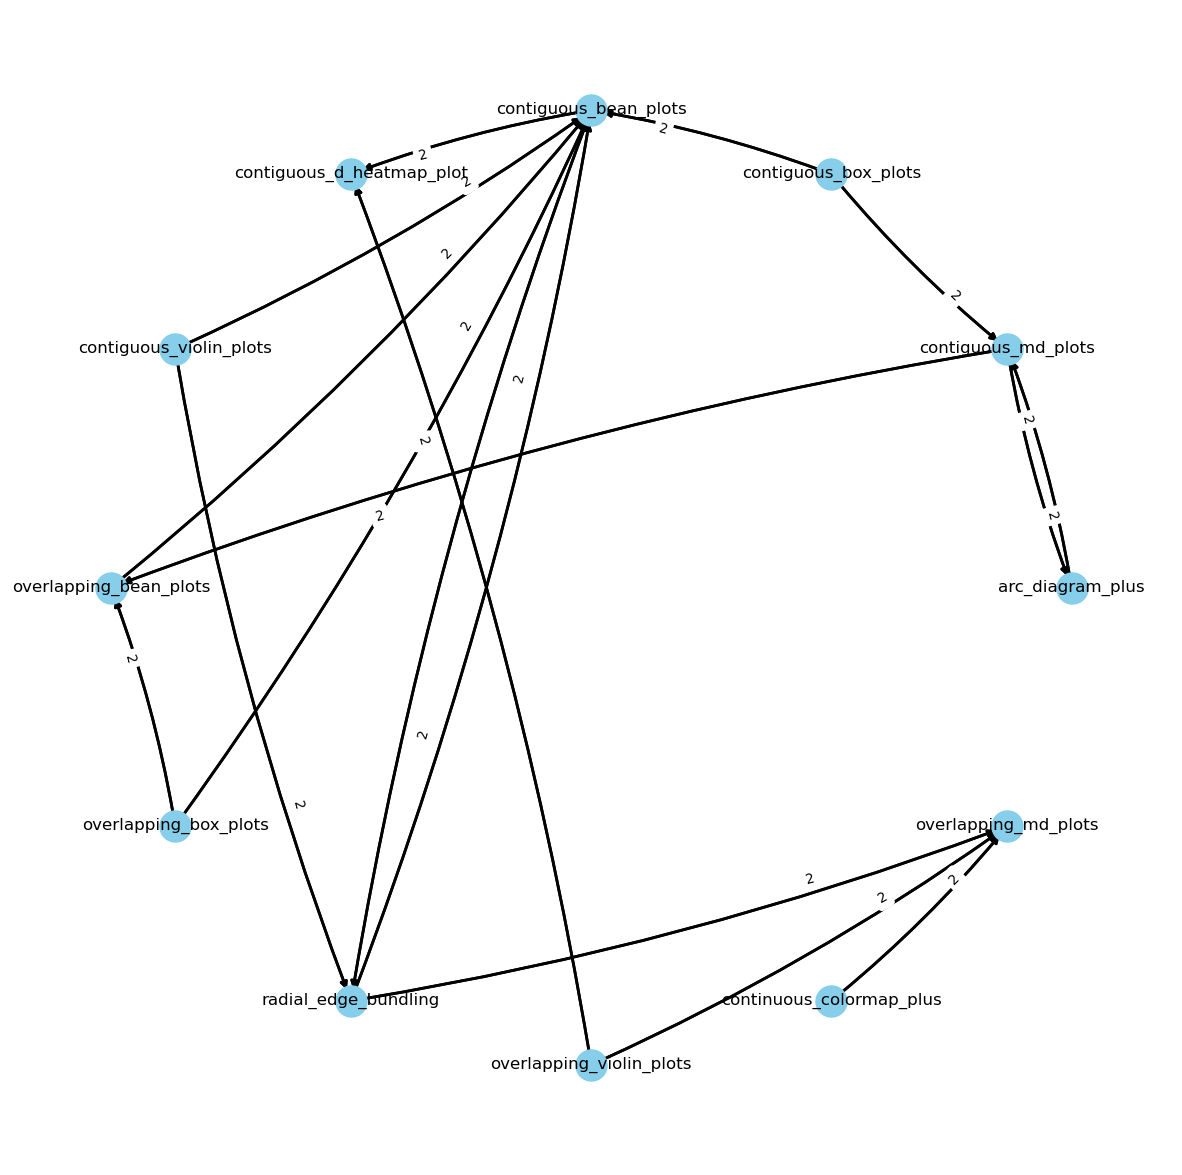

In [99]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming solutions_names and dist_matrix are defined properly

G = nx.MultiDiGraph()  # Use MultiDiGraph to allow multiple directed edges between nodes

threshold = 2

for i in solutions_names:
    for j in solutions_names:
        if dist_matrix.loc[i, j] >= threshold:
            # Add multiple directed edges between nodes
            G.add_edge(i, j, weight=dist_matrix.loc[i, j])
        if dist_matrix.loc[j, i] >= threshold:
            G.add_edge(j, i, weight=dist_matrix.loc[j, i])  # Add edge in reverse direction

# Specify a layout algorithm
# pos = nx.spring_layout(G)
# circular layout
pos = nx.circular_layout(G)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color="skyblue")

curved_edges = [(u, v) for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, edgelist=curved_edges, ax=ax, width=2, arrows=True, connectionstyle='arc3, rad=0.05')

# Draw edge labels with offset
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, label_pos=0.3)

# Draw node labels
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_color="black")

# Show the plot
plt.axis('off')  # Turn off axis
plt.show()


In [100]:
import copy


def get_kernel(G: nx.MultiDiGraph):
    # Create a new directed graph
    G2 = copy.deepcopy(G)

    while True:
        # remove all nodes with out-degree equal to 0 and in-degree not equal to 0
        nodes_to_remove = [node for node in G2.nodes() if G2.out_degree(node) == 0 and G2.in_degree(node) != 0]
        
        if len(nodes_to_remove) == 0:
            break
        
        G2.remove_nodes_from(nodes_to_remove)

    return G2


def get_kernel(G: nx.MultiDiGraph):
    # Create a new directed graph
    G2 = copy.deepcopy(G)

    while True:
        # remove all nodes with out-degree equal to 0 and in-degree not equal to 0
        nodes_to_remove = [node for node in G2.nodes() if G2.out_degree(node) == 0 and G2.in_degree(node) != 0]
        
        if len(nodes_to_remove) == 0:
            break
        
        G2.remove_nodes_from(nodes_to_remove)

    return G2

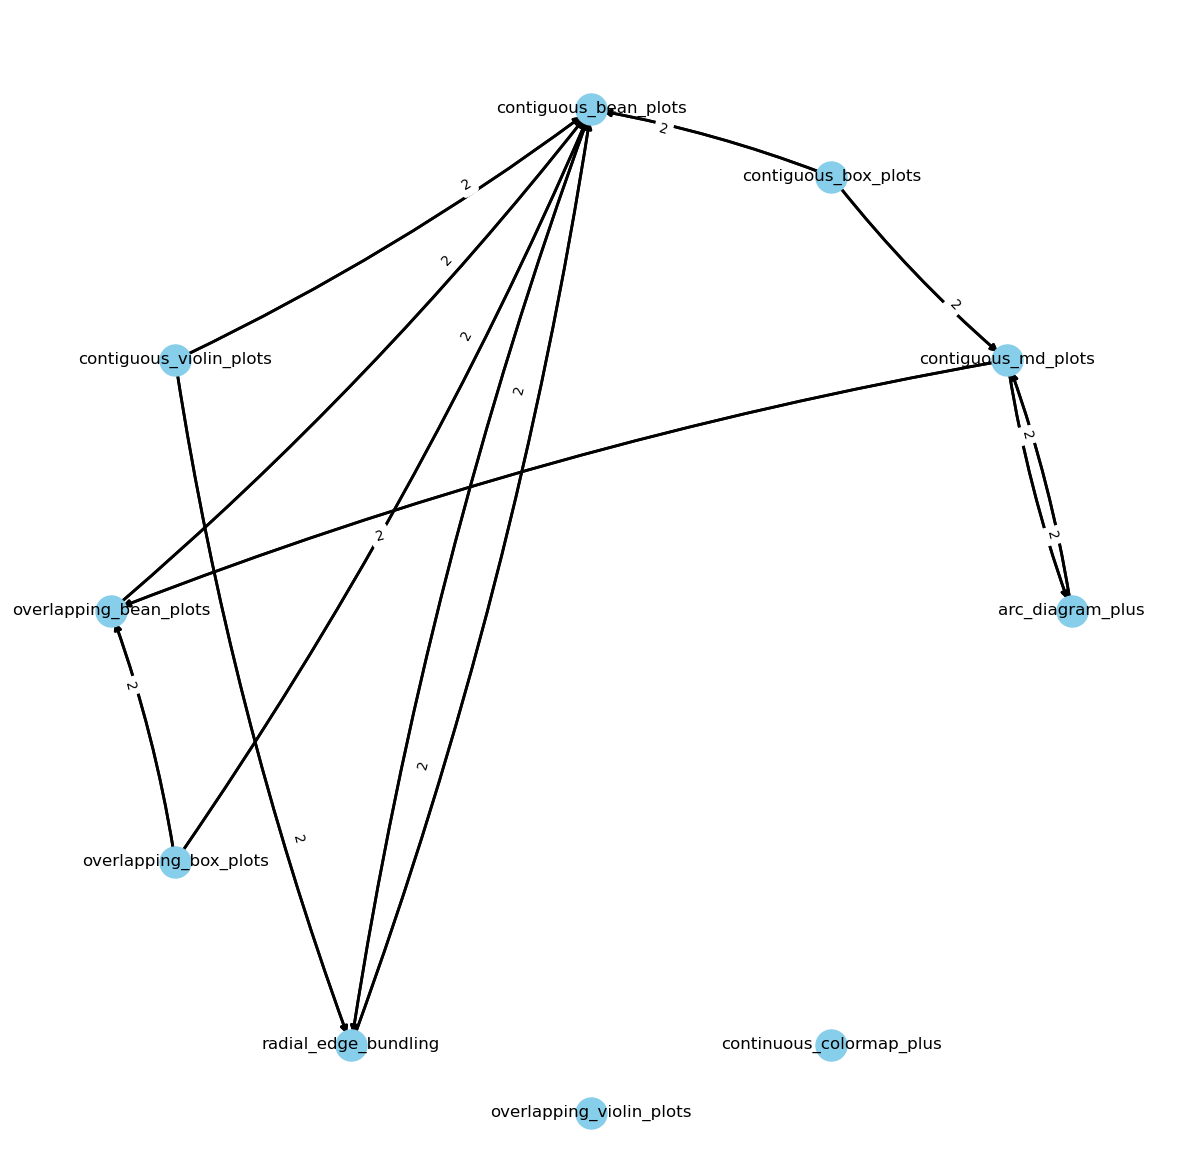

In [101]:
# select the kernel of the graph
kernel = get_kernel(G)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size as needed

# Draw nodes
nx.draw_networkx_nodes(kernel, pos, ax=ax, node_size=500, node_color="skyblue")

curved_edges = [(u, v) for (u, v, d) in kernel.edges(data=True)]
nx.draw_networkx_edges(kernel, pos, edgelist=curved_edges, ax=ax, width=2, arrows=True, connectionstyle='arc3, rad=0.05')

# Draw edge labels with offset
edge_labels = {(u, v): d['weight'] for u, v, d in kernel.edges(data=True)}
nx.draw_networkx_edge_labels(kernel, pos, edge_labels=edge_labels, ax=ax, label_pos=0.3)

# Draw node labels
nx.draw_networkx_labels(kernel, pos, ax=ax, font_size=12, font_color="black")

# Show the plot
plt.axis('off')  # Turn off axis
plt.show()

